<a href="https://colab.research.google.com/github/Eduard953/Image_Processing_SS20/blob/master/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing SS 20 - Assignment - 10

### Deadline is 01.07.2020 at 11:55 am

Eduard Beiline, Bernard Breljak

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.linalg
from skimage.color import rgb2gray
from skimage.data import chelsea
from scipy.fftpack import dct, idct
from numpy.fft import fft2 as numpy_fft2
import math

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - Hadamard Matrix - 5 Points

Create a [hadamard matrix](https://en.wikipedia.org/wiki/Hadamard_matrix) of order n and apply it to the chessboard and sinus boards.

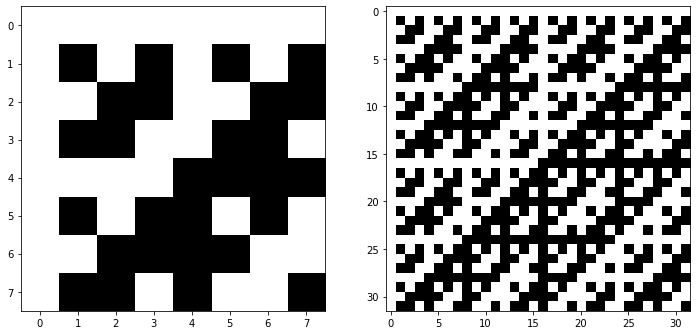

In [3]:
def hadamard_matrix(n):
    """Returns the Hadamard matrix. N is a power of two."""
    if n < 1:
        rec = 0
    else:
        rec = int(math.log(n, 2))

    H = np.array([[1]])

    # Sylvester's construction for n elem 2^n
    for i in range(0, rec):
        H = np.vstack((np.hstack((H, H)), np.hstack((H, -H))))

    return H
    #return scipy.linalg.hadamard(n) / np.sqrt(n) # Weiss nicht wieso das hier ist. Hab dieses Sylvester Ding aus Wiki benutzt. Also kp.

plt.subplot(121)
plt.imshow(hadamard_matrix(8), cmap='gray')
plt.subplot(122)
plt.imshow(hadamard_matrix(32), cmap='gray')
plt.show()

In [4]:
def get_chess_board(n=8, field_size=8):
    board = np.zeros((n*field_size, n*field_size))
    s = field_size
    for i in range(n):
        for j in range(n):
            if (i + j) % 2 == 0:
                board[i*s:(i+1)*s, j*s:(j+1)*s] = 1
    return board

def get_sinus_board(n=8, field_size=8, shift=0):
    img_size = n*field_size
    linsp = np.linspace(-shift, np.pi*n - shift, img_size).reshape((img_size, 1))
    return np.dot(np.sin(linsp), np.sin(linsp.T))



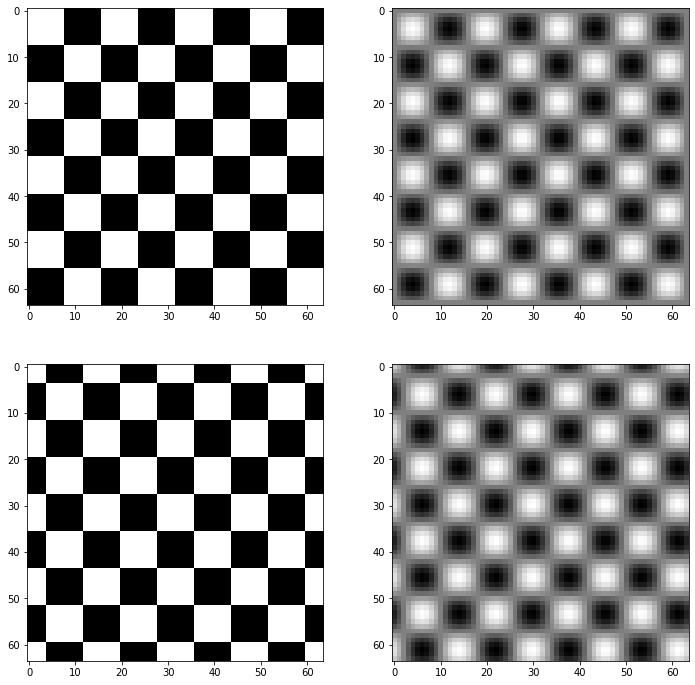

In [5]:
chess_board = get_chess_board()
chess_board_roll = np.roll(np.roll(chess_board, 4, axis=0), 4, axis=1)
sinus_board = get_sinus_board()
sinus_board_roll = get_sinus_board(shift=4)
plt.subplot(221)
plt.imshow(chess_board, cmap='gray', interpolation='nearest')
plt.subplot(222)
plt.imshow(sinus_board, cmap='gray')
plt.subplot(223)
plt.imshow(chess_board_roll, cmap='gray', interpolation='nearest')
plt.subplot(224)
plt.imshow(sinus_board_roll, cmap='gray')
plt.show()

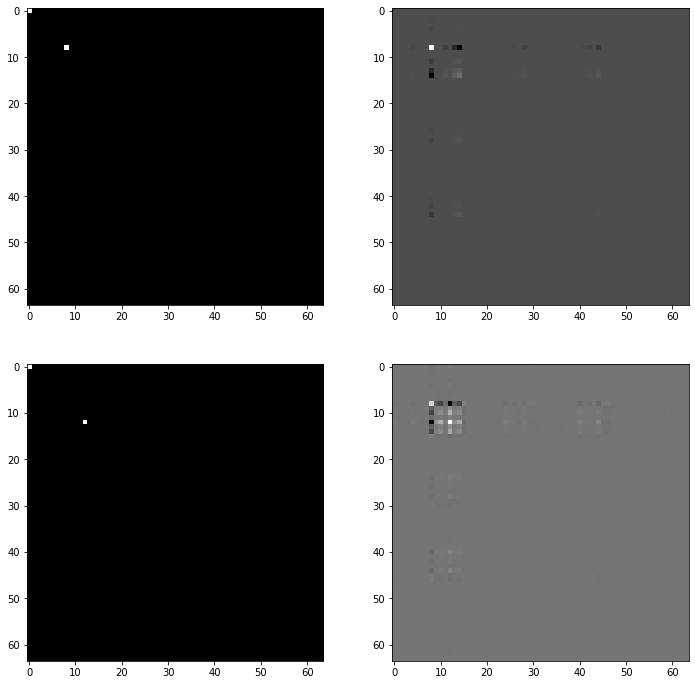

In [6]:
# Plot the 2d hadamard transformation of the chess boards and sinus boards.
# The 2D Hadamard Transformation can be computed similar to the 2D DFT:
# H * I * H, where I is the image, H is the hadamard-matrix and * is the matrix multiplication.

H = hadamard_matrix(64)

chess_board_H = (H @ chess_board) @ H         # your code here  # Bin nicht sicher ob mans so macht, aber steht im letzten comment von goehring so
chess_board_roll_H = (H @ chess_board_roll) @ H
sinus_board_H = (H @ sinus_board) @ H
sinus_board_roll_H = (H @ sinus_board_roll) @ H

plt.subplot(221)
plt.imshow(chess_board_H, cmap='gray', interpolation='nearest')
plt.subplot(222)
plt.imshow(sinus_board_H, cmap='gray')
plt.subplot(223)
plt.imshow(chess_board_roll_H, cmap='gray', interpolation='nearest')
plt.subplot(224)
plt.imshow(sinus_board_roll_H, cmap='gray')
plt.show()

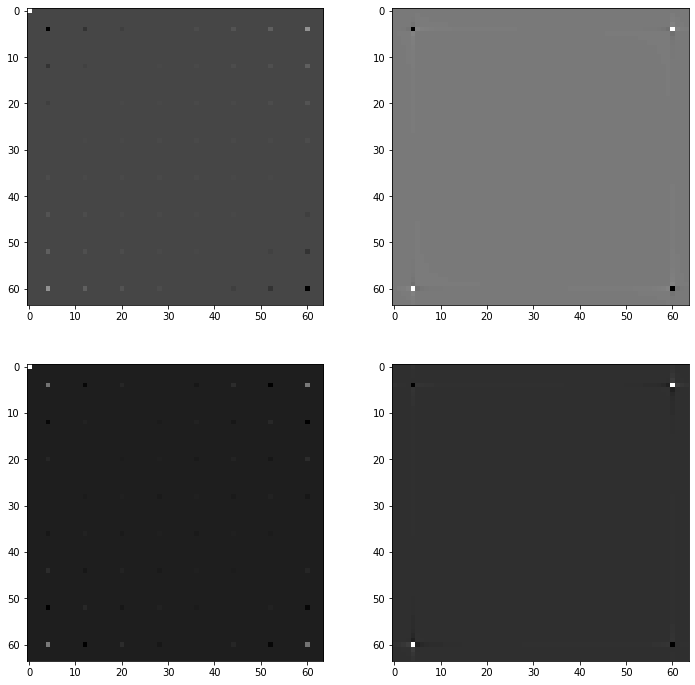

In [7]:
# Plot the fourier transformation of chess boards and sinus boards. 
# You can use some functions from np.ftt
chess_board_ft = numpy_fft2(chess_board)                     # your code here
chess_board_roll_ft = numpy_fft2(chess_board_roll)
sinus_board_ft = numpy_fft2(sinus_board)
sinus_board_roll_ft = numpy_fft2(sinus_board_roll)

plt.subplot(221)
plt.imshow(chess_board_ft.real, cmap='gray', interpolation='nearest')
plt.subplot(222)
plt.imshow(sinus_board_ft.real, cmap='gray')
plt.subplot(223)
plt.imshow(chess_board_roll_ft.real, cmap='gray', interpolation='nearest')
plt.subplot(224)
plt.imshow(sinus_board_roll_ft.real, cmap='gray')
plt.show()

# Exercise 2 - Compare DCT with Discrete Hadamard Transformation - 5 Points
## This assignment uses solutions from the last assignment. We will update this assignment on Wednesday.

Transform the cat image with DCT and WHT (Walsh Hadamard Transformation).
Erase **75 percent** of coefficients. For DCT you can set the last 75% of the ZigZag Ordering to 0. For Hadamard you have to bring the matrices into [sequence ordering](http://fourier.eng.hmc.edu/e161/lectures/wht/node3.html) first and then erase from the ZigZag Ordering.

Transform back into image space and calculate the average quadratic pixel error w.r.t. the original image. 

Plot window size vs DCT and Hadamard and show the MSE error for WindowSizes 8x8, 32x32, 64x64, 128x128 and 256x256
for DCT and DWalHadT respectively.

In [8]:
class Blocks:
    """Transforms an image to blocks. A (512, 512) image will become an (64, 64, 8, 8) numpy array"""
    def __init__(self, block_size=8):
        self.block_size = block_size

    def __call__(self, img):
        b = self.block_size
        height, width = img.shape

        assert img.shape[0] % b == 0
        assert img.shape[1] % b == 0
        blocks = np.zeros((height // b, width // b, b, b), dtype=img.dtype)
        for i in range(0, height // b):
            for j in range(0, width // b):
                blocks[i, j] = img[i*b:(i+1)*b, j*b:(j+1)*b]
        return blocks
    def invert(self, blocks):
        bh, bw = blocks.shape[:2]
        b = self.block_size
        heigth, width = (bh*self.block_size, bw*self.block_size)

        img = np.zeros((heigth, width), dtype=blocks.dtype)
        for i in range(0, bh):
            for j in range(0, bw):
                img[i*b:(i+1)*b, j*b:(j+1)*b] = blocks[i, j]
        return img

In [9]:
class DCTofBlocks:
    def __call__(self, blocks):
        """Returns the DCT of the blocks. The position (i, j) is a 2-dim numpy array with the dct coefficents."""
        # you can use any function from np.fft or scipy.fftpack
        result = numpy_fft2(blocks)
        for row in range(0,blocks.shape[0]):
            for column in range(0,blocks.shape[1]):
                result[row][column] = dct(dct(blocks[row][column], axis=0, norm='ortho' ), axis=1, norm='ortho' )
        return result

    def invert(self, blocks):
        """Computes the inverse DCT."""
        # you can use any function from np.fft or scipy.fftpack
        result = numpy_fft2(blocks)
        for row in range(0,blocks.shape[0]):
            for column in range(0,blocks.shape[1]):
                result[row][column] = idct(idct(blocks[row][column], axis=0 , norm='ortho'), axis=1 , norm='ortho')
        return result

In [10]:
class HadamardofBlocksSequenceOrdering:
    def __call__(self, blocks):
      
      # liest die jumps in der frequenz
      def sign_changes(input):
              empty_list = []
              for a in range(len(input)):
                prev = input[a][0] 
                ret = 0
                for elem in input[a]: 
                  if elem == 0: 
                    sign = -1
                  else: 
                    sign = elem / abs(elem) 
                  if sign == -prev: 
                    ret = ret + 1
                    prev = sign 
                empty_list.append(ret)
              return empty_list

      # convertiert int zu binary 
      def convert_to_binary(x):
        return "{:03b}".format(x)

      #konvertiert binary zu gray code
      def convert_gray(binary):
        binary = int(binary, 2)
        binary ^= (binary >> 1)
        return bin(binary)[2:]

      #spiegelt gray code
      def reverse_bits_table(n):
        neww=''.join(reversed(n))
        return neww

      # erstellt die sequence
      def create_seq(input):
        new_list = []
        for a in sign_changes(input):
          new_list.append(int(convert_gray(reverse_bits_table(convert_to_binary(a))),2))
        return new_list

      # reordered den input nach der sequence
      def reorder(input, seq):
        ret = np.zeros((input.shape[0],input.shape[1]))
        for a in seq:
          ret[seq[a]] = input[a]  
        return ret

      # reordered den block
      h = hadamard_matrix(blocks.shape[3])
      reorder(h, create_seq(h))
      blocks = (h @ blocks) @ h

      return blocks

    def invert(self, blocks):

      # liest die jumps in der frequenz
      def sign_changes(input):
              empty_list = []
              for a in range(len(input)):
                prev = input[a][0] 
                ret = 0
                for elem in input[a]: 
                  if elem == 0: 
                    sign = -1
                  else: 
                    sign = elem / abs(elem) 
                  if sign == -prev: 
                    ret = ret + 1
                    prev = sign 
                empty_list.append(ret)
              return empty_list

      # convertiert int zu binary 
      def convert_to_binary(x):
        return "{:03b}".format(x)

      #konvertiert binary zu gray code
      def convert_gray(binary):
        binary = int(binary, 2)
        binary ^= (binary >> 1)
        return bin(binary)[2:]

      #spiegelt gray code
      def reverse_bits_table(n):
        neww=''.join(reversed(n))
        return neww

      # erstellt die sequence
      def create_seq(input):
        new_list = []
        for a in sign_changes(input):
          new_list.append(int(reverse_bits_table(convert_gray(convert_to_binary(a))),2))
        return new_list

      # reordered den input nach der sequence
      def reorder(input, seq):
        ret = np.zeros((input.shape[0],input.shape[1]))
        for a in seq:
          ret[seq[a]] = input[a]  
        return ret

      h = hadamard_matrix(blocks.shape[3])

      return blocks

In [11]:
class ZigZag:
    def __init__(self, n):
        self.n = n
        """Adapted from here: https://rosettacode.org/wiki/Zig-zag_matrix#Python"""
        def key(pair):
            x, y = pair
            return x+y, -y if (x+y) % 2 else y

        indexorder = sorted(((x,y) for x in range(n) for y in range(n)), key=key)
        self.xs = np.zeros((self.n**2,), dtype=np.int)
        self.ys = np.zeros((self.n**2,), dtype=np.int)
        self.back = np.zeros((n, n), dtype=np.int)
        for i, (x, y) in enumerate(indexorder):
            self.xs[i] = x
            self.ys[i] = y
            self.back[x, y] = i

    def __call__(self, blocks):
        bh, bw, h, w = blocks.shape
        zigzack_blocks = np.zeros((bh, bw, h*w), dtype=blocks.dtype)
        for i, block_row in enumerate(blocks):
            for j, block in enumerate(block_row):
                zigzack_blocks[i, j] = block[self.xs, self.ys]
        return zigzack_blocks

    def invert(self, zigzack_blocks):
        bh, bw, hw = zigzack_blocks.shape
        h = int(np.sqrt(hw))
        blocks = np.zeros((bh, bw, h, h), dtype=zigzack_blocks.dtype)
        for i, zigzack_row in enumerate(zigzack_blocks):
            for j, zigzack in enumerate(zigzack_row):
                blocks[i, j] = zigzack[self.back]
        return blocks

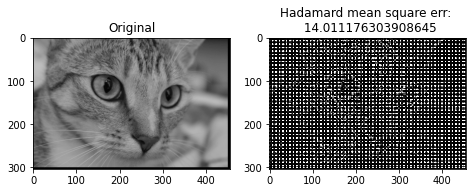

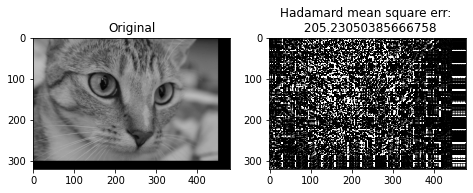

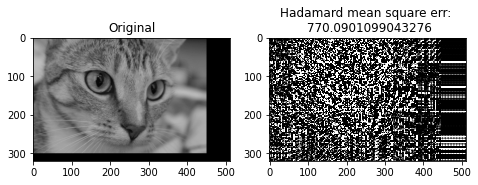

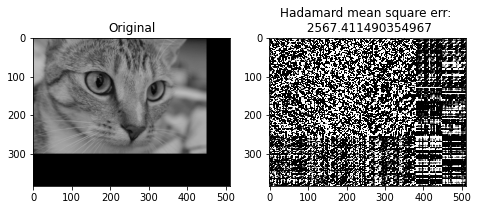

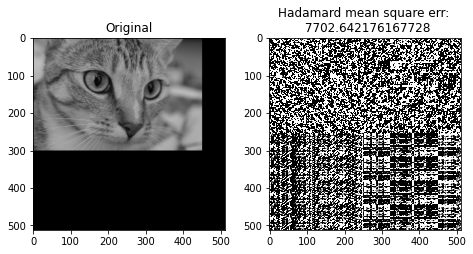

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


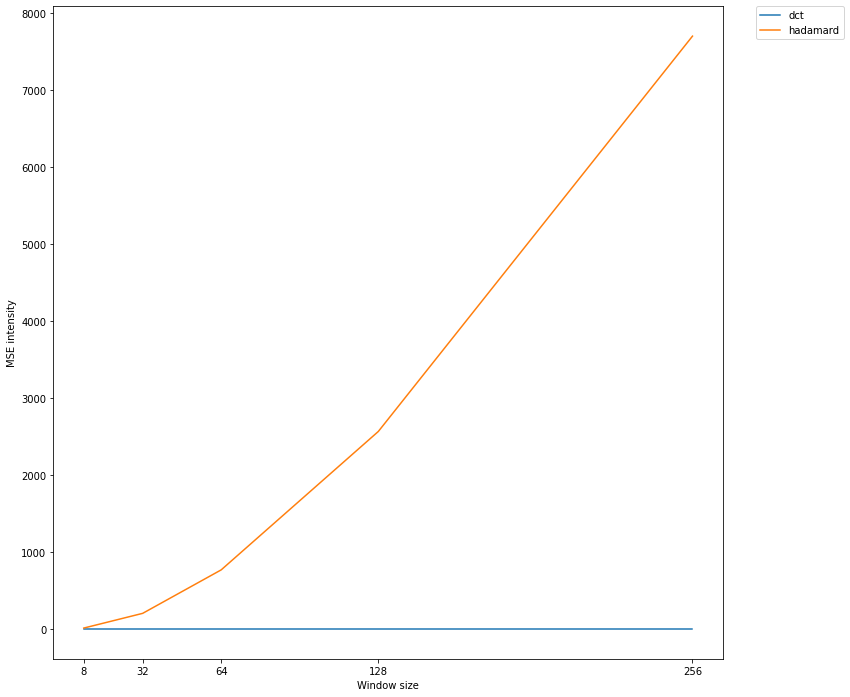

In [12]:
class PickNZigZag:
    def __init__(self, n=1):
        self.n = n

    def __call__(self, blocks):
        """Pick the nth-first frequencies from zigzag ordering"""
        # your code here
        return blocks

    def invert(self, blocks):
        """There is no way to invert this operation. Just return the inputs."""
        return blocks

img = rgb2gray(chelsea())
sizes = [8, 32, 64, 128, 256]
rms_dct_arr = []
rms_hadamard_arr = []
for size in sizes:
    # pad image for blocking
    pad_x = 0 if img.shape[0] % size == 0 else (img.shape[0] // size + 1) * size - img.shape[0]
    pad_y = 0 if img.shape[1] % size == 0 else (img.shape[1] // size + 1) * size - img.shape[1]
    img_pad = np.pad(img, ((0, pad_x), (0, pad_y)))

    blocks = Blocks(block_size=size)(img_pad)
    dct_blocks = DCTofBlocks()(blocks.copy())
    hadamard_blocks = HadamardofBlocksSequenceOrdering()(blocks.copy())

    dct_highest = PickNZigZag(size ** 2 // 4)(dct_blocks)
    hadamard_highest = PickNZigZag(size ** 2 // 4)(hadamard_blocks)

    dct_img = Blocks(block_size=size).invert(DCTofBlocks().invert(dct_highest))
    hadamard_img = Blocks(block_size=size).invert(HadamardofBlocksSequenceOrdering().invert(hadamard_highest))

    mse_dct = ((img_pad - dct_img)**2.0).mean(axis=None)
    mse_hadamard = ((img_pad - hadamard_img)**2.0).mean(axis=None)

    rms_dct_arr.append(mse_dct)
    rms_hadamard_arr.append(mse_hadamard)

    plt.subplot(331)
    plt.title("Original")
    plt.imshow(img_pad, cmap='gray', vmin=0, vmax=1)
    plt.subplot(332)
    #plt.title("DCT mean square err: \n" + str(mse_dct))
    #plt.imshow(dct_img, cmap='gray', vmin=0, vmax=1)
    #plt.subplot(333)
    plt.title("Hadamard mean square err: \n " + str(mse_hadamard))
    plt.imshow(hadamard_img, cmap='gray', vmin=0, vmax=1)
    plt.show()

plt.plot(sizes, rms_dct_arr, label="dct")
plt.plot(sizes, rms_hadamard_arr, label="hadamard")
plt.ylabel("MSE intensity")
plt.xlabel("Window size")
plt.xticks(sizes)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()